In [1]:
# Standard library imports
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Third party imports
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

2023-09-25 16:03:23.402456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 16:03:23.923030: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 16:03:23.927569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 16:03:42.967824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Exploratory Data Analysis 

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


Let's rename the features for better clarity. 
Side note: **'Username Num Ratio'** refers to the ratio of numerical characters to the total length of the username.

In [3]:
feature_rename_map = {
    'profile pic': 'Profile Pic',
    'nums/length username': 'Username Num Ratio',
    'fullname words': 'Fullname Word Count',
    'nums/length fullname': 'Fullname Num Ratio',
    'name==username': 'Name-Username Match',
    'description length': 'Description Length',
    'external URL': 'Has External URL',
    'private': 'Is Private',
    '#posts': 'Post Count',
    '#followers': 'Follower Count',
    '#follows': 'Following Count',
    'fake': 'Is Fake'
}

df = df.rename(columns=feature_rename_map)

In [11]:
df.dtypes

Profile Pic              int64
Username Num Ratio     float64
Fullname Word Count      int64
Fullname Num Ratio     float64
Name-Username Match      int64
Description Length       int64
Has External URL         int64
Is Private               int64
Post Count               int64
Follower Count           int64
Following Count          int64
Is Fake                  int64
dtype: object

In [12]:
df.describe()

,Profile Pic,Username Num Ratio,Fullname Word Count,Fullname Num Ratio,Name-Username Match,Description Length,Has External URL,Is Private,Post Count,Follower Count,Following Count,Is Fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [16]:
df.isnull().sum()

Profile Pic            0
Username Num Ratio     0
Fullname Word Count    0
Fullname Num Ratio     0
Name-Username Match    0
Description Length     0
Has External URL       0
Is Private             0
Post Count             0
Follower Count         0
Following Count        0
Is Fake                0
dtype: int64

In [15]:
df["Is Fake"].value_counts()

Is Fake
0    288
1    288
Name: count, dtype: int64

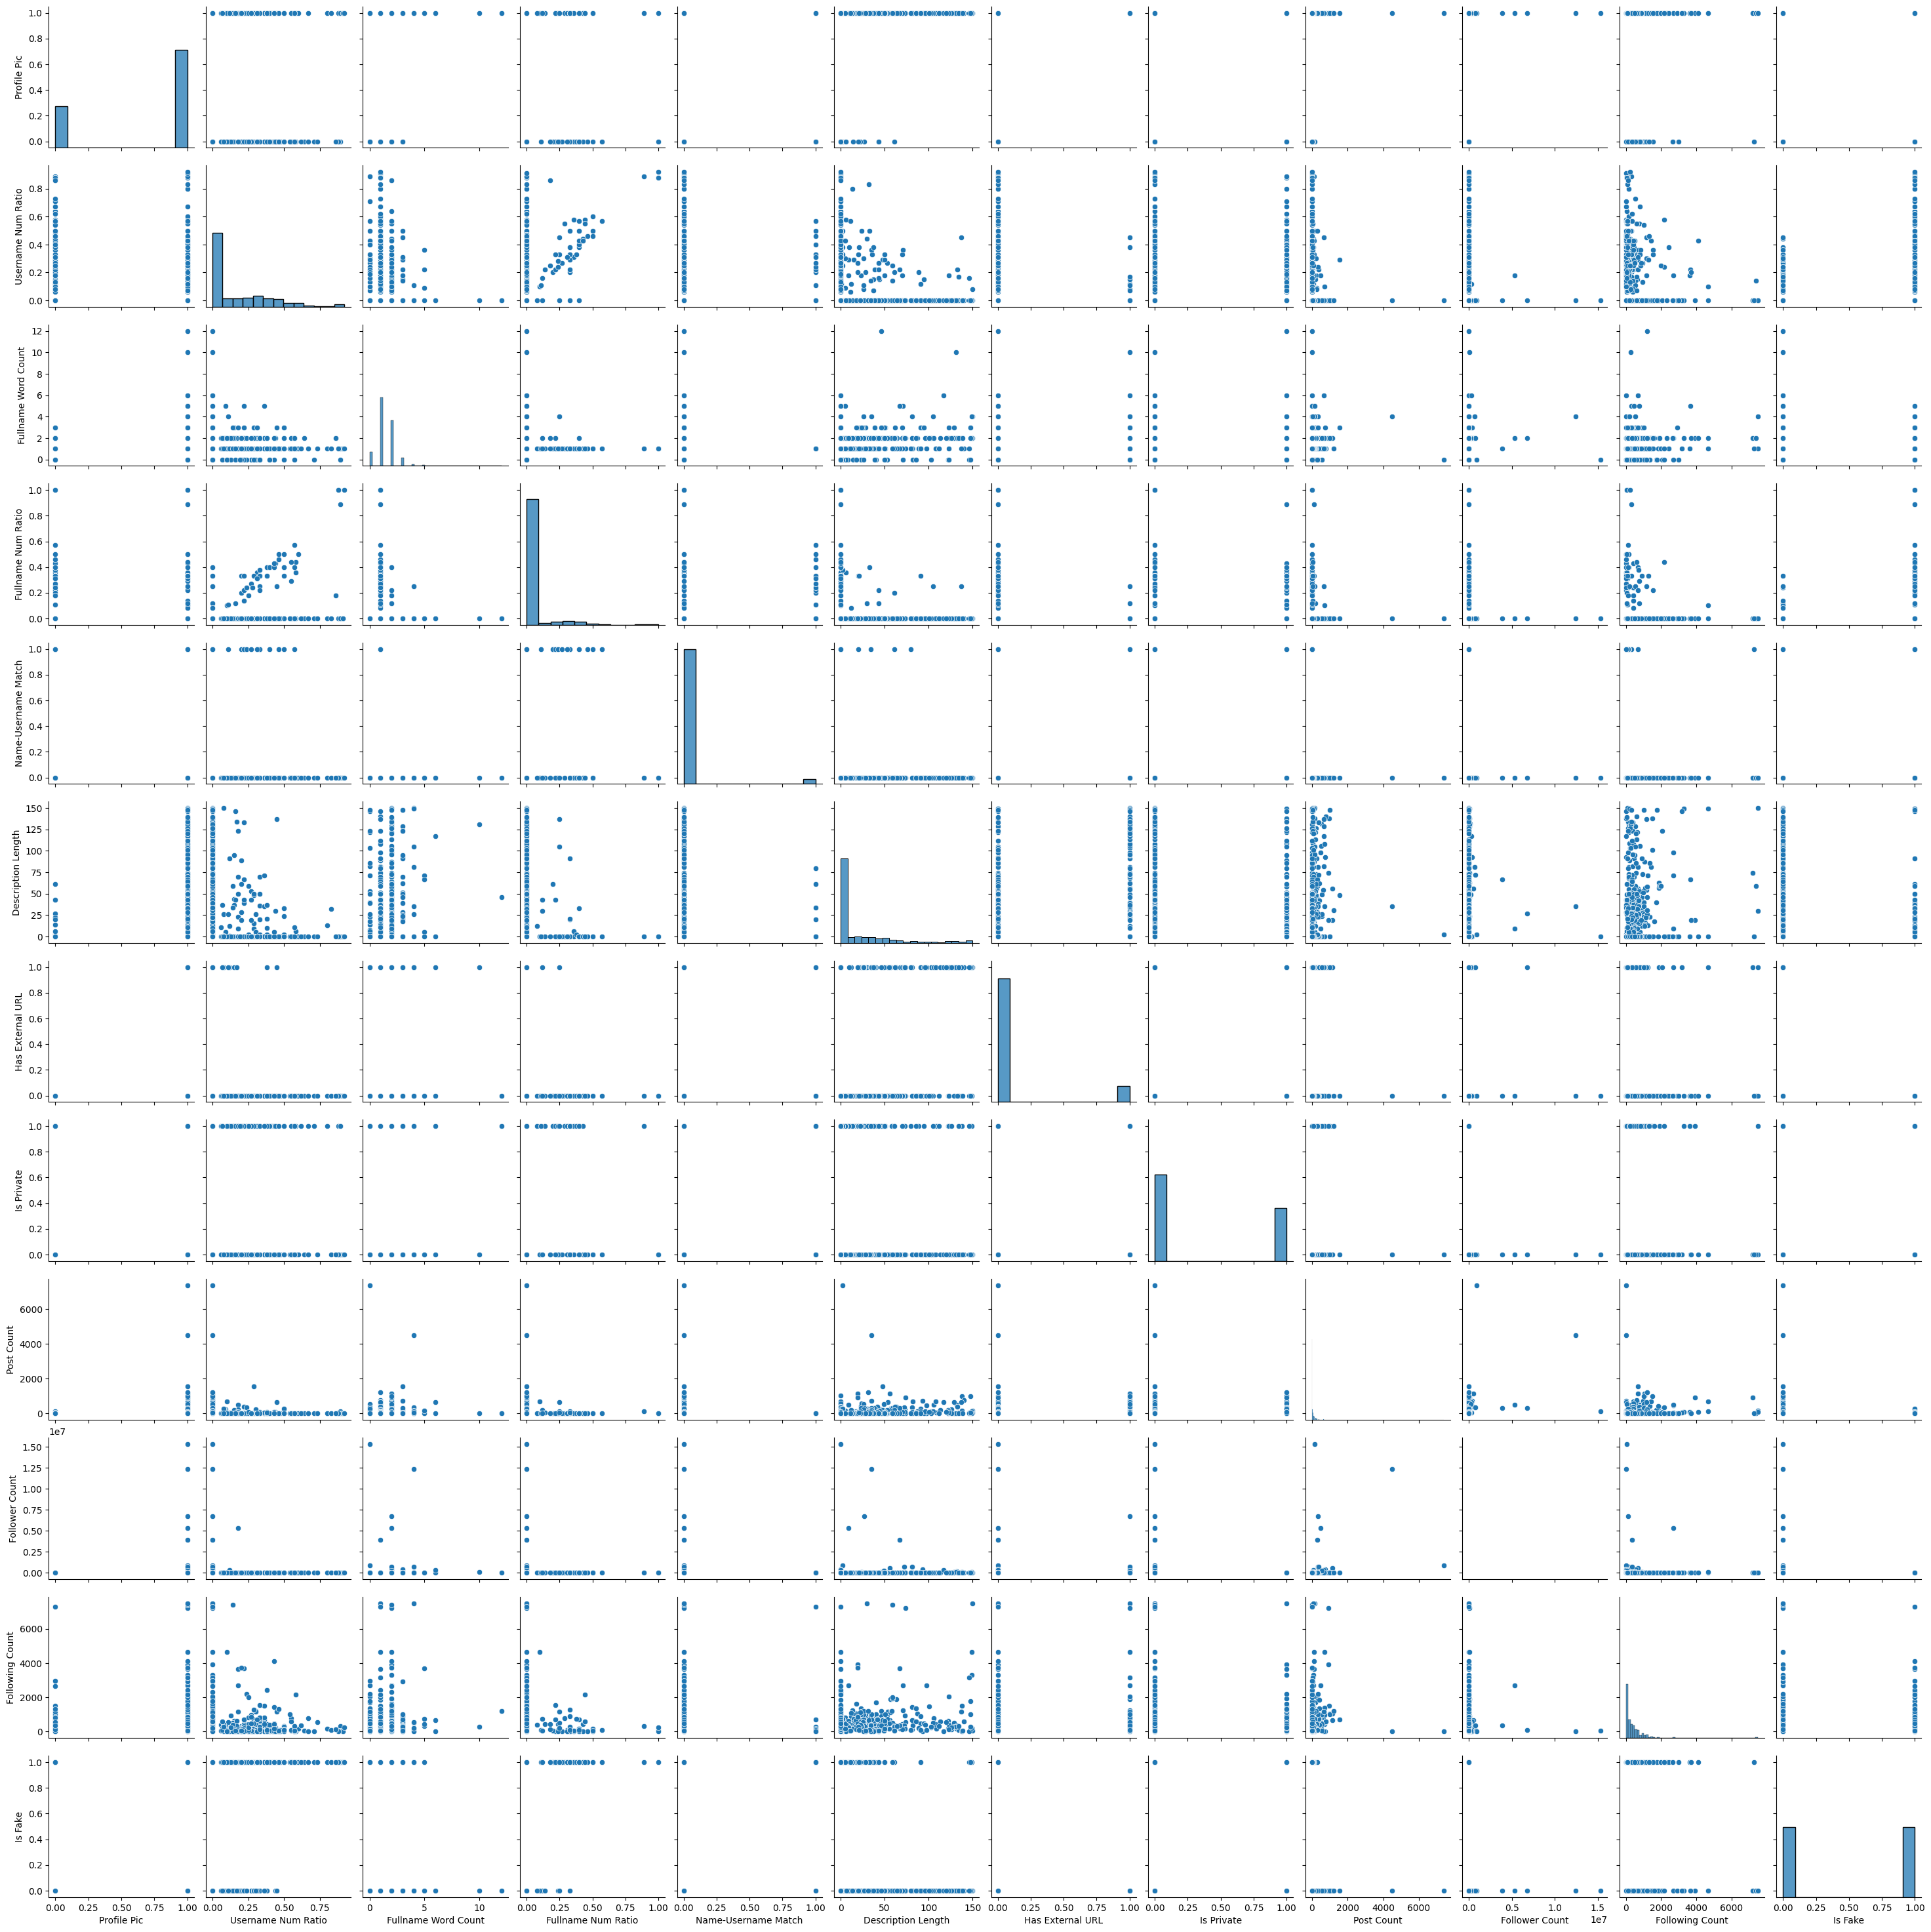

In [24]:
sns.pairplot(df)

Let's check the **mutual information (MI) score** to get a feeling for the most important features:

<Axes: xlabel='MI Scores', ylabel='Features'>

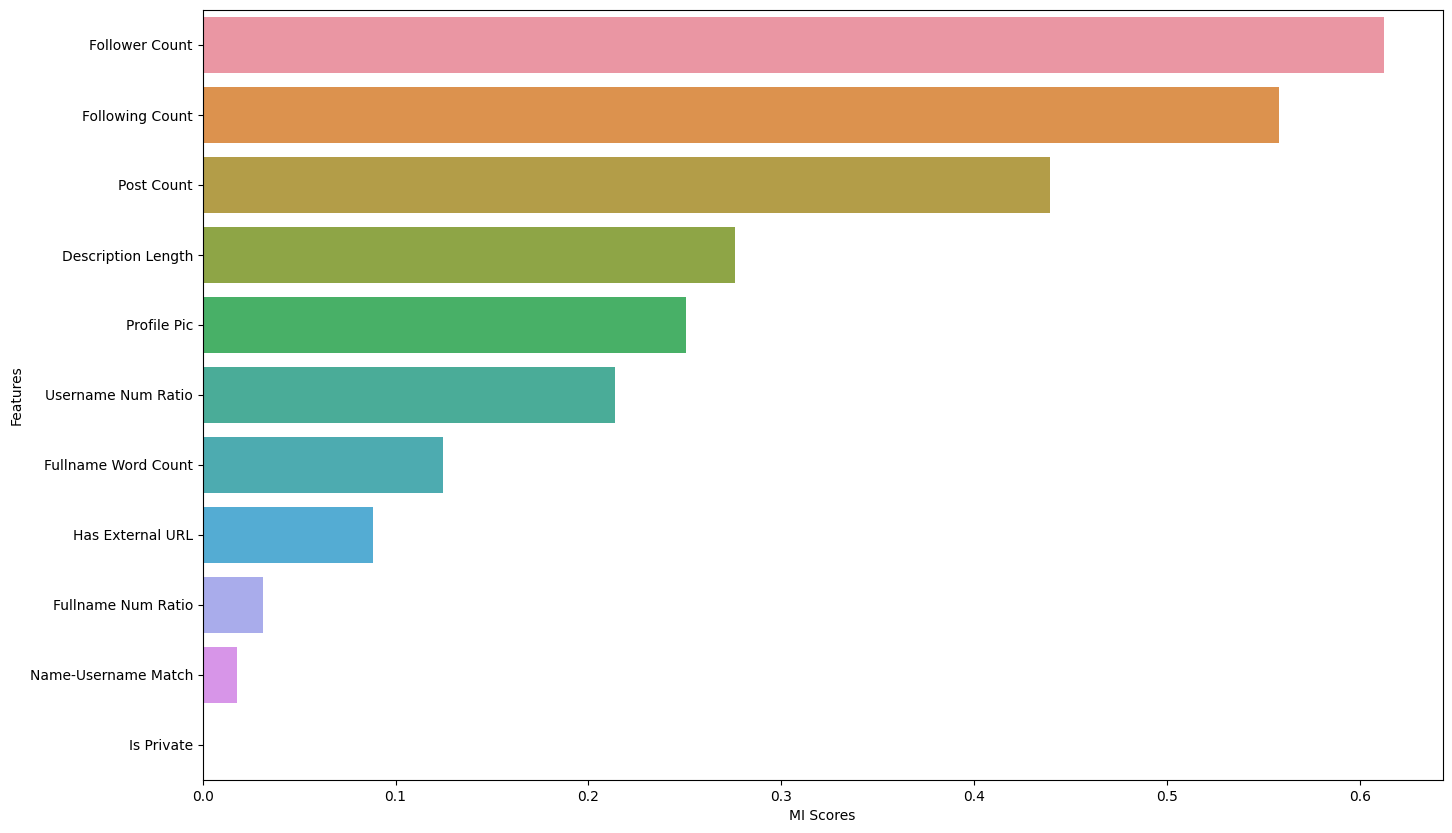

In [14]:
# Drop some columns for now (we're gonna handle them later on)
X_mi = df.copy()
y_mi = X_mi.pop("Is Fake")

# Identify discrete features
discrete_features = X_mi.dtypes == int

# Function to calculate mutual information scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Calculate mutual information scores
mi_scores = make_mi_scores(X_mi, y_mi, discrete_features)

# Plot the scores
plt.figure(figsize=(16,10))
plt.ylabel("Features")
sns.barplot(x=mi_scores, y=mi_scores.index)

**Observation:** It’s clear that characteristics such as the “Follower Count” are pivotal in identifying whether an account is fake.

Next, Let's check the **permutation importance (PI)** of the features with a quick a dirty model: 

In [15]:
# Drop some columns for now (we're gonna handle them later on)
X_pi = df.copy()
y_pi = X_pi.pop("Is Fake") 

X_train, X_val, y_train, y_val = train_test_split(X_pi, y_pi, random_state=1)
my_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

# Define a scorer for Mean Absolute Error
f1_scorer = make_scorer(f1_score)

# Calculate the scores
perm = PermutationImportance(my_model, scoring=f1_scorer, random_state=1).fit(X_val, y_val)

# Display the weights of permutation importance
eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top=None)

Weight,Feature
0.0782 ± 0.0295,Follower Count
0.0387 ± 0.0115,Profile Pic
0.0339 ± 0.0231,Username Num Ratio
0.0184 ± 0.0166,Post Count
0.0102 ± 0.0133,Description Length
0.0095 ± 0.0064,Fullname Word Count
0.0064 ± 0.0137,Following Count
0.0041 ± 0.0104,Is Private
0.0012 ± 0.0049,Name-Username Match
0.0002 ± 0.0086,Has External URL


Let's visualize the importance of the follower count:

<Axes: xlabel='Follower Count', ylabel='Count'>

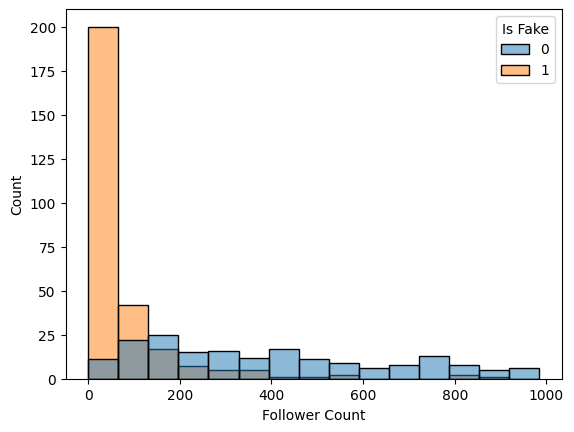

In [17]:
small_df = df.copy().query("`Follower Count` < 1000") # Getting rid of extrem outliers
sns.histplot(data=small_df, x='Follower Count', hue='Is Fake')

**Observation:** Clearly, a very small number of followers is an indicator that the account is probably fake.

Let's check out what fake account mostly have in common: 

In [12]:
df.query("`Is Fake` == 0").iloc[:20]

,Profile Pic,Username Num Ratio,Fullname Word Count,Fullname Num Ratio,Name-Username Match,Description Length,Has External URL,Is Private,Post Count,Follower Count,Following Count,Is Fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0
5,1,0.00,4,0.0,0,81,1,0,344,669987,150,0
6,1,0.00,2,0.0,0,50,0,0,16,122,177,0
7,1,0.00,2,0.0,0,0,0,0,33,1078,76,0
8,1,0.00,0,0.0,0,71,0,0,72,1824,2713,0
9,1,0.00,2,0.0,0,40,1,0,213,12945,813,0


In [13]:
df.query("`Is Fake` == 1").iloc[:20]

,Profile Pic,Username Num Ratio,Fullname Word Count,Fullname Num Ratio,Name-Username Match,Description Length,Has External URL,Is Private,Post Count,Follower Count,Following Count,Is Fake
288,0,0.22,1,0.00,0,0,0,0,0,90,333,1
289,0,0.38,1,0.00,0,0,0,0,0,60,31,1
290,0,0.43,1,0.00,0,0,0,1,2,271,445,1
291,1,0.00,0,0.00,0,0,0,1,3,1,80,1
292,1,0.50,3,0.00,0,24,0,1,13,158,309,1
293,0,0.31,2,0.00,0,0,0,0,0,39,64,1
294,0,0.22,1,0.22,0,43,0,1,1,0,11,1
295,0,0.00,1,0.00,0,0,0,1,0,0,853,1
296,1,0.25,1,0.00,0,0,0,1,10,0,23,1
297,0,0.00,2,0.00,0,0,0,0,0,12,5,1


**Learning:** In the majority of cases, fake accounts tend to have a significantly higher count of users they are following compared to their follower count.
A good idea for **feature engineering** would be to add a Follower/Following ratio:

/tmp/ipykernel_12191/1532014524.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=small_df.query("`Follow Ratio` < 2"), x='Follow Ratio', hue='Is Fake', shade=True)


<Axes: xlabel='Follow Ratio', ylabel='Density'>

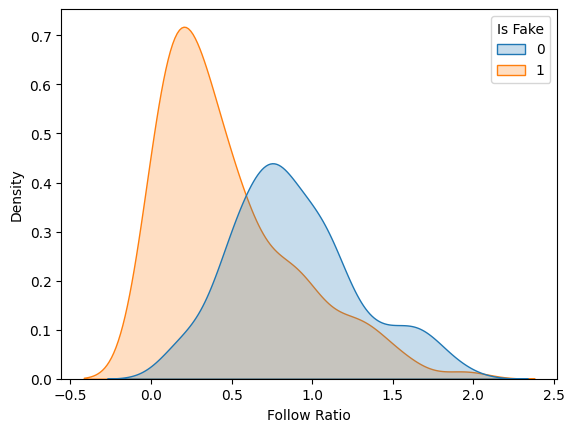

In [19]:
small_df["Follow Ratio"] = small_df["Follower Count"] / small_df["Following Count"] 
sns.kdeplot(data=small_df.query("`Follow Ratio` < 2"), x='Follow Ratio', hue='Is Fake', shade=True)

**Observation:** Clearly, a small ratio is an indicator that the account is probably fake.

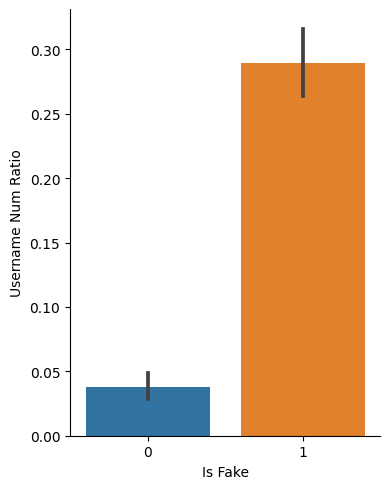

In [23]:
sns.catplot(data=df, x="Is Fake", y="Username Num Ratio", kind="bar", height=5, aspect=.8)

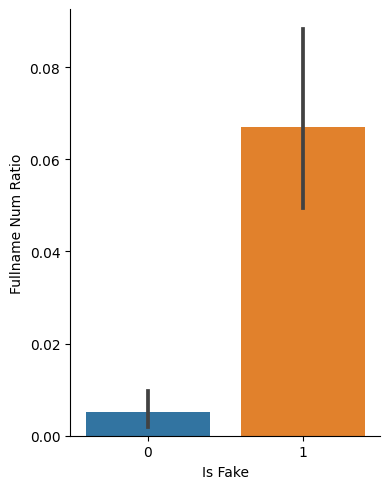

In [24]:
sns.catplot(data=df, x="Is Fake", y="Fullname Num Ratio", kind="bar", height=5, aspect=.8)

<Axes: xlabel='Username Num Ratio', ylabel='Fullname Num Ratio'>

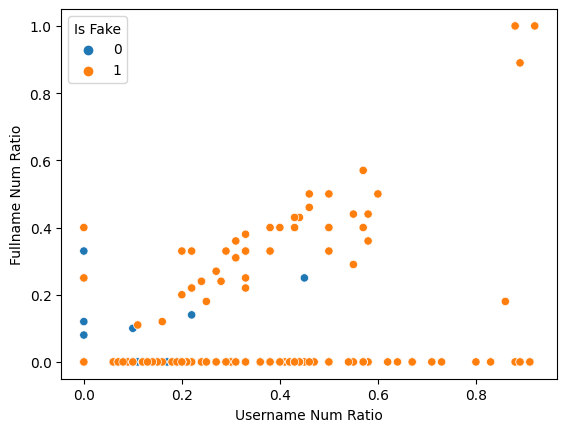

In [27]:
sns.scatterplot(x=df['Username Num Ratio'], y=df['Fullname Num Ratio'], hue=df['Is Fake'])